<a href="https://colab.research.google.com/github/cyclingdata/Birds/blob/master/Birds_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision: Kookaburra or cockatoo?

This is an adaptation of the famous Kaggle competition cats vs dogs. I just decided to make this a little more 'Australian' :)

I have downloaded 500 pictures of Kookaburras and cockatoos, in two different directories


The first step is to connect to my Google account as I stored the pictures on a GCS bucket

In [0]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

Copy the two directories: one for Kookaburras, one for cockatoos

In [0]:
import os

try:
  os.mkdir('/tmp/images/')
  os.mkdir('/tmp/images/Cockatoos')
  os.mkdir('/tmp/images/Kookaburras')
except OSError:
    pass


In [3]:
!gsutil -m cp -r  gs://kooka-or-cockatoo/images/Cockatoos /tmp/images/
!gsutil -m cp -r  gs://kooka-or-cockatoo/images/Kookaburras /tmp/images/

Copying gs://kooka-or-cockatoo/images/Cockatoos/01-0715_l_600x.progressive.jpg...
Copying gs://kooka-or-cockatoo/images/Cockatoos/0a04f4bd53cd10218cf7b41623cf2f6e.jpg...
Copying gs://kooka-or-cockatoo/images/Cockatoos/10899962-3x2-940x627-e1554331787679.jpg...
Copying gs://kooka-or-cockatoo/images/Cockatoos/117500131.jpg...
Copying gs://kooka-or-cockatoo/images/Cockatoos/117500151.jpg...
Copying gs://kooka-or-cockatoo/images/Cockatoos/130222_web.jpg...
Copying gs://kooka-or-cockatoo/images/Cockatoos/1300307_600_450_2_0_fit_0_ddca08a92d57c547ab27ee07057aceae.jpg...
Copying gs://kooka-or-cockatoo/images/Cockatoos/170px-Sulphur_Crested_Cockatoo_Nov10.jpg...
Copying gs://kooka-or-cockatoo/images/Cockatoos/146741142-jurong-bird-park-yellow-crested-cockatoo-singapore-observing.jpg...
Copying gs://kooka-or-cockatoo/images/Cockatoos/18814515-cockatoo-in-botanic-garden-of-sydney-australia.jpg...
Copying gs://kooka-or-cockatoo/images/Cockatoos/2-yellow-crested-cockatoo-rob-downer.jpg...
Copying 

We need to split data into training and test. We will keep 70% of images for training and 30% for testing

In [0]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  # list files in source dir
  files = os.listdir(SOURCE)
  # split training validation
  nb_files = len(files)
  shuffle = random.sample(files,nb_files)
  training_files = shuffle[:round(SPLIT_SIZE*nb_files)]
  validation_files = shuffle[round(SPLIT_SIZE*nb_files):]
  for fname in training_files:
    if os.path.getsize(os.path.join(SOURCE,fname)) > 0:
      copyfile(os.path.join(SOURCE, fname),os.path.join(TRAINING, fname))
    else:
      print(fname + ' is zero length, so ignoring.')
  for fname in validation_files:
    if os.path.getsize(os.path.join(SOURCE,fname)) > 0:
      copyfile(os.path.join(SOURCE, fname),os.path.join(TESTING, fname))
    else:
      print(fname + ' is zero length, so ignoring.')

# create directories
try:
  os.mkdir("/tmp/kooka-v-cockatoo/")
  os.mkdir("/tmp/kooka-v-cockatoo/training/")
  os.mkdir("/tmp/kooka-v-cockatoo/training/Kookaburras")
  os.mkdir("/tmp/kooka-v-cockatoo/training/Cockatoos")
  os.mkdir("/tmp/kooka-v-cockatoo/testing/")
  os.mkdir("/tmp/kooka-v-cockatoo/testing/Kookaburras")
  os.mkdir("/tmp/kooka-v-cockatoo/testing/Cockatoos")
except OSError:
    pass

KOOKA_SOURCE_DIR = "/tmp/images/Kookaburras/"
TRAINING_KOOKA_DIR = "/tmp/kooka-v-cockatoo/training/Kookaburras/"
TESTING_KOOKA_DIR = "/tmp/kooka-v-cockatoo/testing/Kookaburras/"
COCKATOO_SOURCE_DIR = "/tmp/images/Cockatoos/"
TRAINING_COCKATOO_DIR = "/tmp/kooka-v-cockatoo/training/Cockatoos/"
TESTING_COCKATOO_DIR = "/tmp/kooka-v-cockatoo/testing/Cockatoos/"

split_size = .7
split_data(KOOKA_SOURCE_DIR, TRAINING_KOOKA_DIR, TESTING_KOOKA_DIR, split_size)
split_data(COCKATOO_SOURCE_DIR, TRAINING_COCKATOO_DIR, TESTING_COCKATOO_DIR, split_size)

Download InceptionV3 model - we will then build our model on top on this neural network. Since there are a lot of parameters on this model it's best to put all layers as not trainable (ie fix the values of those parameters)

In [5]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-03-30 23:40:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  53.8MB/s    in 1.6s    

2020-03-30 23:40:15 (53.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


Use image augmentation to avoid overfitting: on the train dataset, we allow to rotate, shift zoom or flip the picture. This way on each epoch the model will train on slightly different images.

In [11]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/kooka-v-cockatoo/training/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/kooka-v-cockatoo/testing/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='binary'
)

from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 128 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

Found 335 images belonging to 2 classes.
Found 143 images belonging to 2 classes.


Fit the model. Keep the metrics in history to plot them later

In [12]:
# divide lr by 2 if loss does not improve in 2 consecutive epochs
rlrop = ReduceLROnPlateau(monitor='loss',factor=0.5,patience=2)
# stop if loss has not improve in 5 consecutive epochs	
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 30,
            epochs = 150,
            validation_steps = 10,
            verbose = 1,
            callbacks =[rlrop,es])

Epoch 1/150
30/30 [==============================] - 17s 580ms/step - loss: 0.5492 - accuracy: 0.7516 - val_loss: 0.0602 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 2/150
30/30 [==============================] - 16s 537ms/step - loss: 0.1961 - accuracy: 0.9208 - val_loss: 0.0929 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 3/150
30/30 [==============================] - 16s 543ms/step - loss: 0.1715 - accuracy: 0.9362 - val_loss: 0.0542 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 4/150
30/30 [==============================] - 16s 547ms/step - loss: 0.2099 - accuracy: 0.9276 - val_loss: 0.1930 - val_accuracy: 0.9685 - lr: 0.0010
Epoch 5/150
30/30 [==============================] - 17s 551ms/step - loss: 0.1812 - accuracy: 0.9219 - val_loss: 0.0888 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 6/150
30/30 [==============================] - 16s 525ms/step - loss: 0.1352 - accuracy: 0.9439 - val_loss: 0.1274 - val_accuracy: 0.9790 - lr: 5.0000e-04
Epoch 7/150
30/30 [==============================] - 1

Plot the loss and accuracy to see if we are not overfitting

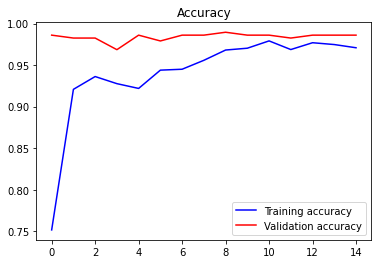

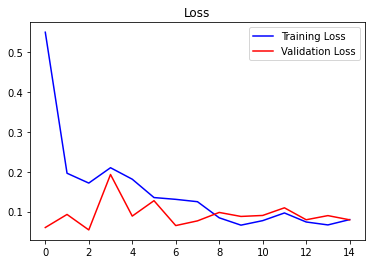

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',color='red')
plt.title('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss',color='red')
plt.title('Loss')
plt.legend()

plt.show()

Save the model and copy to GCS bucket

In [18]:
model.save('birds_model.h5') 
!gsutil -m cp -r  birds_model.h5 gs://kooka-or-cockatoo/birds_model.h5

Copying file://birds_model.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/90.0 MiB.                                     
